In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, TimeDistributed
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

S_P_500 = pd.read_csv('Data/bitcoin without lag.csv')
S_P_data = S_P_500.reset_index(drop=True)

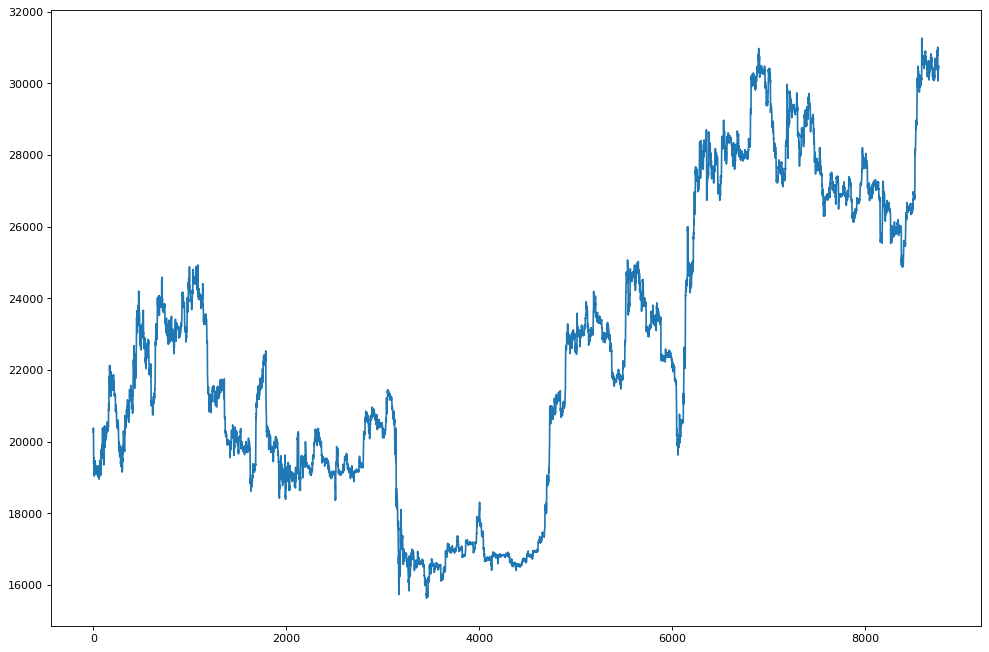

In [2]:
# Time series plot of S&P 500 data
figure(figsize=(15, 10), dpi=80)
time_x = S_P_data.index
time_y = S_P_data['close']
plt.plot(time_x,time_y)
plt.show()

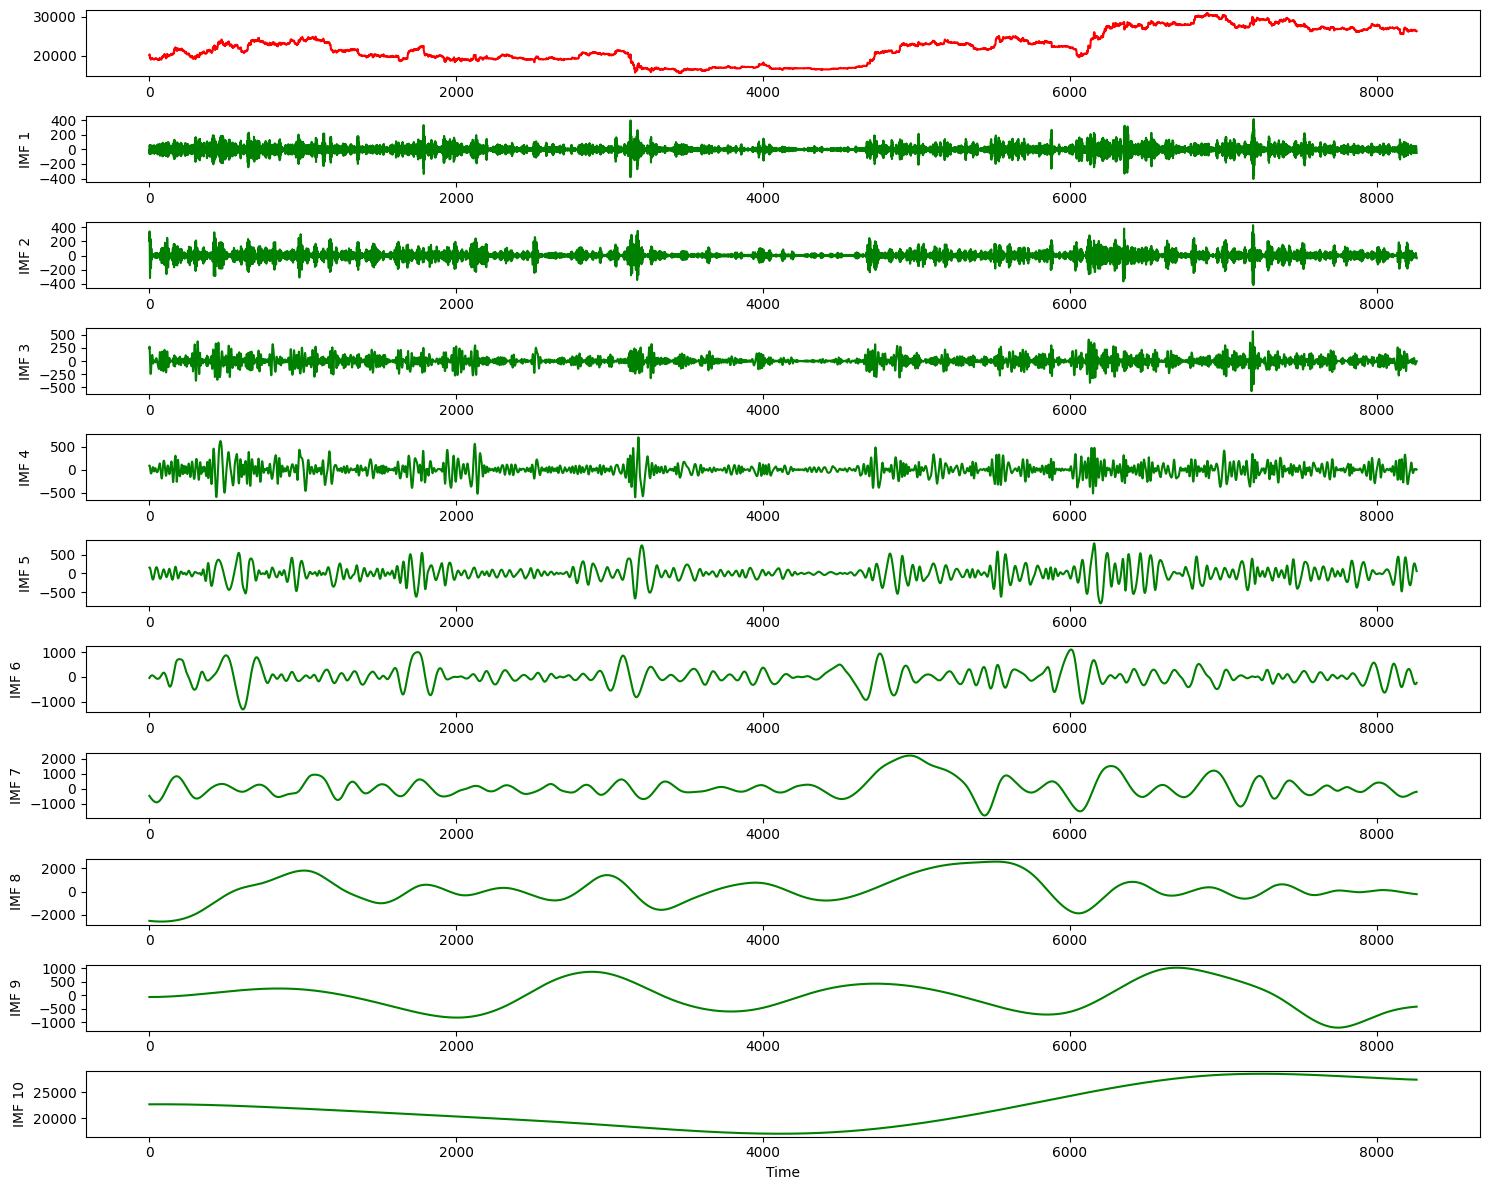

In [5]:
Signal = S_P_data['close'][0:len(S_P_data.index)-500].to_numpy()
T = S_P_data.loc[0:len(S_P_data.index)-501].index.to_numpy()
from PyEMD import EMD
emd = EMD()
IMFs = emd(Signal, max_imf=10)
nIMFs = len(IMFs)

# visualize the subsequences getting from the original signal
plt.figure(figsize = (15,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(T, Signal, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs + 1, 1, n + 2)
    plt.plot(T, IMFs[n], 'g')
    plt.ylabel("IMF %i" %(n + 1))
    plt.locator_params(axis = 'y', nbins=5)

plt.xlabel("Time")
plt.tight_layout()
plt.savefig('eemd_example', dpi = 120)
plt.show()

### Univariate

In [7]:
# Create dataset by looking specific number of steps back
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# MAPE
import statistics
from sklearn.metrics import mean_squared_error, r2_score

def MAPE(actual, pred):
    assert len(actual) == len(pred), "Input arrays must have the same length."
    error_ = []
    for ii in range(len(actual)):
        absolute_errors = abs((actual[ii] - pred[ii]) / actual[ii])
        error_.append(absolute_errors)
    
    mape = (sum(error_)/len(error_)) * 100.0

    return mape

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

##### EMD LSTM

In [6]:
def perform_LSTM(dataset, look_back, layer = 4, epochs = 100, batch_size = 16, validation_split = 0.2):
  
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the data -- using Min and Max values in each subsequence to normalize the values
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Split data into training and testing set
    train_size = len(dataset) - 500
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(layer, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size,
              verbose = 2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

In [7]:
IMF_predict_list = []
error_list = []
for IMF in IMFs:
    iter_ = len(error_list) + 1
    print(f'========================================Training for IMF: {iter_}========================================')
    IMF_predict, IMF_test, testing_error = perform_LSTM(IMF, 20, layer = 4, epochs = 50,
                                                        batch_size = 32)
    error_list.append(testing_error)
    IMF_predict_list.append(IMF_predict)
    print('')

========================================Training for IMF: 1========================================
Epoch 1/50
242/242 - 5s - loss: 0.0279 - 5s/epoch - 19ms/step
Epoch 2/50
242/242 - 1s - loss: 0.0066 - 820ms/epoch - 3ms/step
Epoch 3/50
242/242 - 1s - loss: 0.0064 - 853ms/epoch - 4ms/step
Epoch 4/50
242/242 - 1s - loss: 0.0062 - 871ms/epoch - 4ms/step
Epoch 5/50
242/242 - 1s - loss: 0.0061 - 836ms/epoch - 3ms/step
Epoch 6/50
242/242 - 1s - loss: 0.0059 - 963ms/epoch - 4ms/step
Epoch 7/50
242/242 - 1s - loss: 0.0058 - 940ms/epoch - 4ms/step
Epoch 8/50
242/242 - 1s - loss: 0.0057 - 977ms/epoch - 4ms/step
Epoch 9/50
242/242 - 1s - loss: 0.0057 - 1s/epoch - 4ms/step
Epoch 10/50
242/242 - 1s - loss: 0.0056 - 887ms/epoch - 4ms/step
Epoch 11/50
242/242 - 1s - loss: 0.0055 - 913ms/epoch - 4ms/step
Epoch 12/50
242/242 - 1s - loss: 0.0054 - 961ms/epoch - 4ms/step
Epoch 13/50
242/242 - 1s - loss: 0.0053 - 931ms/epoch - 4ms/step
Epoch 14/50
242/242 - 1s - loss: 0.0052 - 884ms/epoch - 4ms/step
Epoc

KeyboardInterrupt: 

In [87]:
for i in IMF_predict_list:
    i = i[:,0]

# This nested for loop is used to generate final prediction by adding up the corresponding values in each subsequence
final_prediction = []
for i in range(len(IMF_predict_list[0])):
    element = 0 
    for j in range(len(IMF_predict_list)):
        element += IMF_predict_list[j][i]
    final_prediction = final_prediction + element.tolist()

In [91]:
from sklearn.metrics import r2_score
SP = time_y.astype('float32')
SP = np.reshape(SP.to_numpy(), (-1, 1))

train_size = train_size = len(SP) - 500
test_size = len(SP) - train_size
SP_train, SP_test = SP[0:train_size], SP[train_size:]

SP_testX, SP_testY = create_dataset(SP_test, 20)

# Calculate the RMSE
rmse_error = rmse(SP_testY.tolist(), final_prediction)
mdape_error = MAPE(SP_testY.tolist(), final_prediction)
r2 = r2_score(SP_testY.tolist(), final_prediction)

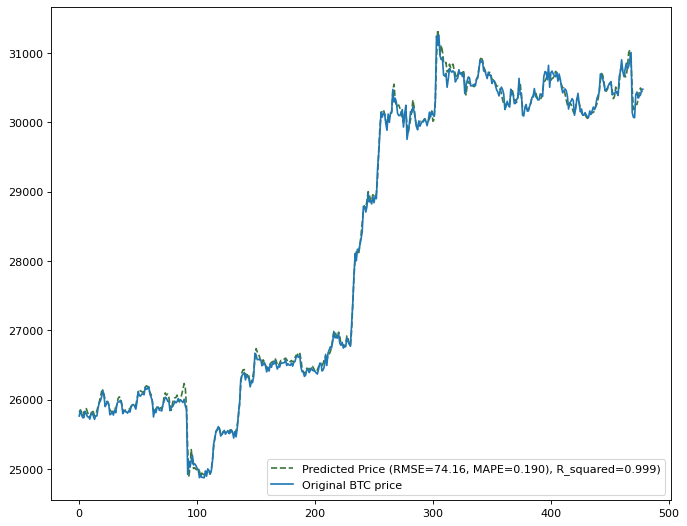

In [94]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction, linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f})".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist(), label = 'Original BTC price')
plt.legend()
plt.show()

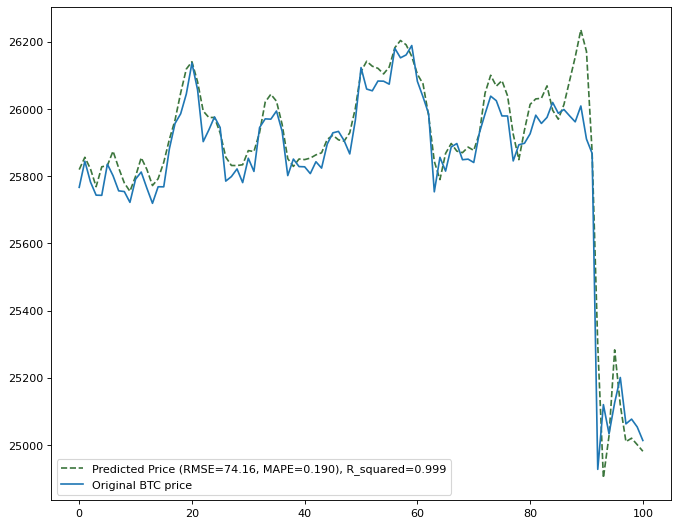

In [95]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction[0:101], linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f}".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist()[0:101], label = 'Original BTC price')
plt.legend()
plt.show()

##### EMD TKAN

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Enable mixed-precision training for speedup on compatible hardware
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) for additional speedup
tf.config.optimizer.set_jit(True)

# Define Deep Spline Activation with tf.function for graph execution
class DeepSplineActivation(layers.Layer):
    def __init__(self, num_knots=10, **kwargs):
        super(DeepSplineActivation, self).__init__(**kwargs)
        self.num_knots = num_knots

    def build(self, input_shape):
        self.knots = self.add_weight(name='knots', 
                                     shape=(self.num_knots,),
                                     initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                     trainable=True)
        self.coefficients = self.add_weight(name='coefficients', 
                                            shape=(self.num_knots-1,),
                                            initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                            trainable=True)
        super(DeepSplineActivation, self).build(input_shape)

    @tf.function
    def call(self, inputs):
        # Assuming knots are pre-sorted during build time, sorting is not needed in every call
        sorted_knots = tf.sort(self.knots)
        differences = tf.nn.relu(inputs[..., None] - sorted_knots)
        spline_output = tf.reduce_sum(differences[..., :-1] * self.coefficients, axis=-1)
        return spline_output

# Define Kolmogorov-Arnold Network (KAN) with multiple neurons
def build_kan_model(input_shape, hidden_units=64, output_units=1, num_knots=10, num_neurons=5):
    inputs = tf.keras.Input(shape=input_shape)
    
    kan_neurons_outputs = []
    deep_spline_activation = DeepSplineActivation(num_knots=num_knots)
    
    for _ in range(num_neurons):
        x = layers.Dense(hidden_units)(inputs)
        x = layers.BatchNormalization()(x)  # Add BatchNormalization for faster convergence
        x = deep_spline_activation(x)
        
        x = layers.Dense(hidden_units)(x)
        x = layers.BatchNormalization()(x)  # Add BatchNormalization for faster convergence
        x = deep_spline_activation(x)
        
        kan_neurons_outputs.append(x)
    
    aggregated_output = layers.Concatenate()(kan_neurons_outputs)
    
    outputs = layers.Dense(output_units)(aggregated_output)
    
    kan_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return kan_model

# Define the LSTM model
def build_lstm_model(input_shape, lstm_units=64):
    model = models.Sequential()
    model.add(layers.LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(lstm_units))
    return model

# Combine LSTM and KAN models with multiple KAN neurons
def build_combined_model(input_shape, lstm_units=64, hidden_units=64, output_units=1, num_knots=10, num_neurons=5):
    lstm_input = tf.keras.Input(shape=input_shape)
    
    lstm_model = build_lstm_model(input_shape, lstm_units=lstm_units)
    lstm_output = lstm_model(lstm_input)
    
    # Flatten the output instead of using reshape (more efficient)
    reshaped_output = layers.Flatten()(lstm_output)
    
    kan_model = build_kan_model((reshaped_output.shape[-1],), hidden_units=hidden_units, output_units=output_units, num_knots=num_knots, num_neurons=num_neurons)
    kan_output = kan_model(reshaped_output)
    
    combined_model = tf.keras.Model(inputs=lstm_input, outputs=kan_output)
    return combined_model

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [7]:
def perform_KAN(dataset, look_back, epochs = 100, batch_size = 16, lstm_units = 20, hidden_units = 20, output_units = 1,
                num_knots = 2, num_neurons = 5):
  
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the data -- using Min and Max values in each subsequence to normalize the values
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Split data into training and testing set
    train_size = len(dataset) - 500
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # Build, compile, and train the model
    input_shape = (1, look_back)

    model = build_combined_model(input_shape, lstm_units=lstm_units, hidden_units=hidden_units,
                                 output_units=output_units, num_knots=num_knots, num_neurons=num_neurons)

    model.compile(loss='mean_squared_error', optimizer = 'adam')
    
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size,verbose = 2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = trainPredict.reshape(-1, trainPredict.shape[-1])
    testPredict = testPredict.reshape(-1, testPredict.shape[-1])

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

In [24]:
IMF_predict_list = []
error_list = []
for IMF in IMFs:
    iter_ = len(error_list) + 1
    print(f'========================================Training for IMF: {iter_}========================================')
    IMF_predict, IMF_test, testing_error = perform_KAN(IMF, 4, epochs = 100, batch_size = 32, lstm_units = 4,
                                                       hidden_units = 4, output_units = 1, num_knots = 2, num_neurons = 4)
    error_list.append(testing_error)
    IMF_predict_list.append(IMF_predict)
    print('')

========================================Training for IMF: 1========================================
Epoch 1/100
243/243 - 29s - loss: 0.0435 - 29s/epoch - 120ms/step
Epoch 2/100
243/243 - 12s - loss: 0.0048 - 12s/epoch - 51ms/step
Epoch 3/100
243/243 - 3s - loss: 0.0047 - 3s/epoch - 14ms/step
Epoch 4/100
243/243 - 3s - loss: 0.0046 - 3s/epoch - 14ms/step
Epoch 5/100
243/243 - 3s - loss: 0.0046 - 3s/epoch - 14ms/step
Epoch 6/100
243/243 - 3s - loss: 0.0046 - 3s/epoch - 14ms/step
Epoch 7/100
243/243 - 4s - loss: 0.0047 - 4s/epoch - 15ms/step
Epoch 8/100
243/243 - 3s - loss: 0.0046 - 3s/epoch - 14ms/step
Epoch 9/100
243/243 - 4s - loss: 0.0046 - 4s/epoch - 14ms/step
Epoch 10/100
243/243 - 3s - loss: 0.0045 - 3s/epoch - 14ms/step
Epoch 11/100
243/243 - 3s - loss: 0.0046 - 3s/epoch - 14ms/step
Epoch 12/100
243/243 - 3s - loss: 0.0045 - 3s/epoch - 14ms/step
Epoch 13/100
243/243 - 3s - loss: 0.0044 - 3s/epoch - 14ms/step
Epoch 14/100
243/243 - 3s - loss: 0.0044 - 3s/epoch - 14ms/step
Epoch 15

Epoch 25/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 26/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 27/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 28/100
243/243 - 3s - loss: 0.0010 - 3s/epoch - 14ms/step
Epoch 29/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 30/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 31/100
243/243 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 32/100
243/243 - 3s - loss: 9.5008e-04 - 3s/epoch - 14ms/step
Epoch 33/100
243/243 - 3s - loss: 9.6727e-04 - 3s/epoch - 14ms/step
Epoch 34/100
243/243 - 3s - loss: 9.6521e-04 - 3s/epoch - 14ms/step
Epoch 35/100
243/243 - 3s - loss: 9.9497e-04 - 3s/epoch - 14ms/step
Epoch 36/100
243/243 - 3s - loss: 9.7774e-04 - 3s/epoch - 14ms/step
Epoch 37/100
243/243 - 3s - loss: 9.7504e-04 - 3s/epoch - 14ms/step
Epoch 38/100
243/243 - 3s - loss: 9.3684e-04 - 3s/epoch - 14ms/step
Epoch 39/100
243/243 - 3s - loss: 9.2518e-04 - 3s/epoch - 14ms/step
Epoch 40

Epoch 43/100
243/243 - 3s - loss: 3.5750e-04 - 3s/epoch - 14ms/step
Epoch 44/100
243/243 - 3s - loss: 3.2197e-04 - 3s/epoch - 14ms/step
Epoch 45/100
243/243 - 3s - loss: 3.5601e-04 - 3s/epoch - 14ms/step
Epoch 46/100
243/243 - 3s - loss: 4.5257e-04 - 3s/epoch - 14ms/step
Epoch 47/100
243/243 - 3s - loss: 3.8878e-04 - 3s/epoch - 14ms/step
Epoch 48/100
243/243 - 3s - loss: 3.4095e-04 - 3s/epoch - 14ms/step
Epoch 49/100
243/243 - 3s - loss: 4.2152e-04 - 3s/epoch - 14ms/step
Epoch 50/100
243/243 - 3s - loss: 4.0131e-04 - 3s/epoch - 14ms/step
Epoch 51/100
243/243 - 3s - loss: 3.3360e-04 - 3s/epoch - 14ms/step
Epoch 52/100
243/243 - 3s - loss: 4.7777e-04 - 3s/epoch - 14ms/step
Epoch 53/100
243/243 - 4s - loss: 3.3057e-04 - 4s/epoch - 15ms/step
Epoch 54/100
243/243 - 3s - loss: 3.8233e-04 - 3s/epoch - 14ms/step
Epoch 55/100
243/243 - 3s - loss: 4.3088e-04 - 3s/epoch - 14ms/step
Epoch 56/100
243/243 - 3s - loss: 3.4067e-04 - 3s/epoch - 14ms/step
Epoch 57/100
243/243 - 3s - loss: 4.8463e-04 - 3

Epoch 62/100
243/243 - 3s - loss: 3.7179e-04 - 3s/epoch - 14ms/step
Epoch 63/100
243/243 - 3s - loss: 2.6729e-04 - 3s/epoch - 14ms/step
Epoch 64/100
243/243 - 3s - loss: 3.1399e-04 - 3s/epoch - 14ms/step
Epoch 65/100
243/243 - 3s - loss: 3.0768e-04 - 3s/epoch - 14ms/step
Epoch 66/100
243/243 - 3s - loss: 2.0133e-04 - 3s/epoch - 14ms/step
Epoch 67/100
243/243 - 3s - loss: 2.6567e-04 - 3s/epoch - 14ms/step
Epoch 68/100
243/243 - 3s - loss: 2.4820e-04 - 3s/epoch - 14ms/step
Epoch 69/100
243/243 - 3s - loss: 2.9101e-04 - 3s/epoch - 14ms/step
Epoch 70/100
243/243 - 3s - loss: 2.5611e-04 - 3s/epoch - 14ms/step
Epoch 71/100
243/243 - 3s - loss: 2.9523e-04 - 3s/epoch - 14ms/step
Epoch 72/100
243/243 - 3s - loss: 3.2348e-04 - 3s/epoch - 14ms/step
Epoch 73/100
243/243 - 3s - loss: 2.3730e-04 - 3s/epoch - 14ms/step
Epoch 74/100
243/243 - 3s - loss: 1.9453e-04 - 3s/epoch - 14ms/step
Epoch 75/100
243/243 - 3s - loss: 1.8240e-04 - 3s/epoch - 14ms/step
Epoch 76/100
243/243 - 3s - loss: 2.1251e-04 - 3

Epoch 80/100
243/243 - 3s - loss: 2.3753e-04 - 3s/epoch - 14ms/step
Epoch 81/100
243/243 - 3s - loss: 2.2592e-04 - 3s/epoch - 14ms/step
Epoch 82/100
243/243 - 3s - loss: 1.9154e-04 - 3s/epoch - 14ms/step
Epoch 83/100
243/243 - 3s - loss: 2.2856e-04 - 3s/epoch - 14ms/step
Epoch 84/100
243/243 - 3s - loss: 1.9055e-04 - 3s/epoch - 14ms/step
Epoch 85/100
243/243 - 3s - loss: 2.1405e-04 - 3s/epoch - 14ms/step
Epoch 86/100
243/243 - 3s - loss: 1.5960e-04 - 3s/epoch - 14ms/step
Epoch 87/100
243/243 - 3s - loss: 1.4107e-04 - 3s/epoch - 14ms/step
Epoch 88/100
243/243 - 3s - loss: 1.6030e-04 - 3s/epoch - 14ms/step
Epoch 89/100
243/243 - 3s - loss: 1.6765e-04 - 3s/epoch - 14ms/step
Epoch 90/100
243/243 - 3s - loss: 1.3148e-04 - 3s/epoch - 14ms/step
Epoch 91/100
243/243 - 3s - loss: 1.6429e-04 - 3s/epoch - 14ms/step
Epoch 92/100
243/243 - 3s - loss: 1.6209e-04 - 3s/epoch - 14ms/step
Epoch 93/100
243/243 - 3s - loss: 1.3557e-04 - 3s/epoch - 14ms/step
Epoch 94/100
243/243 - 3s - loss: 1.4661e-04 - 3

Epoch 98/100
243/243 - 3s - loss: 7.3172e-05 - 3s/epoch - 14ms/step
Epoch 99/100
243/243 - 3s - loss: 7.3441e-05 - 3s/epoch - 13ms/step
Epoch 100/100
243/243 - 3s - loss: 6.8106e-05 - 3s/epoch - 14ms/step
16/16 [==============================] - 0s 3ms/step

========================================Training for IMF: 7========================================
Epoch 1/100
243/243 - 25s - loss: 0.0015 - 25s/epoch - 103ms/step
Epoch 2/100
243/243 - 10s - loss: 0.0010 - 10s/epoch - 41ms/step
Epoch 3/100
243/243 - 3s - loss: 7.1721e-04 - 3s/epoch - 14ms/step
Epoch 4/100
243/243 - 3s - loss: 6.2697e-04 - 3s/epoch - 14ms/step
Epoch 5/100
243/243 - 3s - loss: 4.8074e-04 - 3s/epoch - 14ms/step
Epoch 6/100
243/243 - 3s - loss: 4.6747e-04 - 3s/epoch - 14ms/step
Epoch 7/100
243/243 - 3s - loss: 3.4721e-04 - 3s/epoch - 14ms/step
Epoch 8/100
243/243 - 3s - loss: 2.8785e-04 - 3s/epoch - 14ms/step
Epoch 9/100
243/243 - 3s - loss: 2.0631e-04 - 3s/epoch - 14ms/step
Epoch 10/100
243/243 - 3s - loss: 1.7389e

Epoch 13/100
243/243 - 4s - loss: 4.5739e-04 - 4s/epoch - 15ms/step
Epoch 14/100
243/243 - 4s - loss: 5.7627e-04 - 4s/epoch - 15ms/step
Epoch 15/100
243/243 - 3s - loss: 7.4678e-04 - 3s/epoch - 14ms/step
Epoch 16/100
243/243 - 4s - loss: 3.9864e-04 - 4s/epoch - 14ms/step
Epoch 17/100
243/243 - 4s - loss: 4.0170e-04 - 4s/epoch - 17ms/step
Epoch 18/100
243/243 - 5s - loss: 2.2102e-04 - 5s/epoch - 21ms/step
Epoch 19/100
243/243 - 5s - loss: 1.9182e-04 - 5s/epoch - 19ms/step
Epoch 20/100
243/243 - 4s - loss: 2.0372e-04 - 4s/epoch - 16ms/step
Epoch 21/100
243/243 - 3s - loss: 1.2191e-04 - 3s/epoch - 14ms/step
Epoch 22/100
243/243 - 3s - loss: 1.6325e-04 - 3s/epoch - 14ms/step
Epoch 23/100
243/243 - 3s - loss: 2.1330e-04 - 3s/epoch - 14ms/step
Epoch 24/100
243/243 - 3s - loss: 1.3913e-04 - 3s/epoch - 14ms/step
Epoch 25/100
243/243 - 3s - loss: 1.1486e-04 - 3s/epoch - 13ms/step
Epoch 26/100
243/243 - 3s - loss: 1.1680e-04 - 3s/epoch - 14ms/step
Epoch 27/100
243/243 - 3s - loss: 1.4874e-04 - 3

Epoch 31/100
243/243 - 3s - loss: 3.3472e-04 - 3s/epoch - 14ms/step
Epoch 32/100
243/243 - 3s - loss: 5.7992e-04 - 3s/epoch - 14ms/step
Epoch 33/100
243/243 - 3s - loss: 3.4344e-04 - 3s/epoch - 14ms/step
Epoch 34/100
243/243 - 3s - loss: 2.6693e-04 - 3s/epoch - 14ms/step
Epoch 35/100
243/243 - 3s - loss: 3.7719e-04 - 3s/epoch - 14ms/step
Epoch 36/100
243/243 - 3s - loss: 1.9582e-04 - 3s/epoch - 14ms/step
Epoch 37/100
243/243 - 3s - loss: 2.8988e-04 - 3s/epoch - 14ms/step
Epoch 38/100
243/243 - 3s - loss: 2.0484e-04 - 3s/epoch - 14ms/step
Epoch 39/100
243/243 - 3s - loss: 2.3868e-04 - 3s/epoch - 14ms/step
Epoch 40/100
243/243 - 3s - loss: 2.7328e-04 - 3s/epoch - 14ms/step
Epoch 41/100
243/243 - 3s - loss: 2.1704e-04 - 3s/epoch - 14ms/step
Epoch 42/100
243/243 - 3s - loss: 0.0014 - 3s/epoch - 13ms/step
Epoch 43/100
243/243 - 3s - loss: 2.5399e-04 - 3s/epoch - 14ms/step
Epoch 44/100
243/243 - 3s - loss: 1.4103e-04 - 3s/epoch - 14ms/step
Epoch 45/100
243/243 - 3s - loss: 1.3057e-04 - 3s/ep

Epoch 49/100
243/243 - 3s - loss: 1.1021e-04 - 3s/epoch - 13ms/step
Epoch 50/100
243/243 - 3s - loss: 4.9093e-05 - 3s/epoch - 14ms/step
Epoch 51/100
243/243 - 3s - loss: 3.9250e-05 - 3s/epoch - 13ms/step
Epoch 52/100
243/243 - 3s - loss: 5.3772e-05 - 3s/epoch - 13ms/step
Epoch 53/100
243/243 - 3s - loss: 5.8069e-05 - 3s/epoch - 14ms/step
Epoch 54/100
243/243 - 3s - loss: 7.2682e-05 - 3s/epoch - 13ms/step
Epoch 55/100
243/243 - 3s - loss: 7.1570e-05 - 3s/epoch - 13ms/step
Epoch 56/100
243/243 - 3s - loss: 9.9603e-05 - 3s/epoch - 13ms/step
Epoch 57/100
243/243 - 3s - loss: 1.0133e-04 - 3s/epoch - 14ms/step
Epoch 58/100
243/243 - 3s - loss: 6.4069e-05 - 3s/epoch - 13ms/step
Epoch 59/100
243/243 - 3s - loss: 4.7362e-05 - 3s/epoch - 13ms/step
Epoch 60/100
243/243 - 3s - loss: 2.9938e-05 - 3s/epoch - 14ms/step
Epoch 61/100
243/243 - 3s - loss: 4.1037e-05 - 3s/epoch - 13ms/step
Epoch 62/100
243/243 - 3s - loss: 3.7765e-05 - 3s/epoch - 13ms/step
Epoch 63/100
243/243 - 3s - loss: 4.9469e-05 - 3

In [25]:
for i in IMF_predict_list:
    i = i[:,0]

# This nested for loop is used to generate final prediction by adding up the corresponding values in each subsequence
final_prediction = []
for i in range(len(IMF_predict_list[0])):
    element = 0 
    for j in range(len(IMF_predict_list)):
        element += IMF_predict_list[j][i]
    final_prediction = final_prediction + element.tolist()

In [29]:
from sklearn.metrics import r2_score
SP = time_y.astype('float32')
SP = np.reshape(SP.to_numpy(), (-1, 1))

train_size = train_size = len(SP) - 500
test_size = len(SP) - train_size
SP_train, SP_test = SP[0:train_size], SP[train_size:]

SP_testX, SP_testY = create_dataset(SP_test, 4)

# Calculate the RMSE
rmse_error = rmse(SP_testY.tolist(), final_prediction)
mdape_error = MAPE(SP_testY.tolist(), final_prediction)
r2 = r2_score(SP_testY.tolist(), final_prediction)

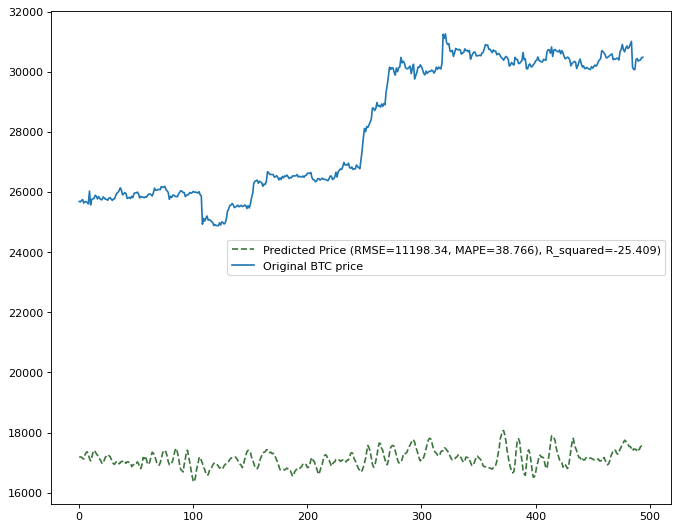

In [30]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction, linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f})".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist(), label = 'Original BTC price')
plt.legend()
plt.show()

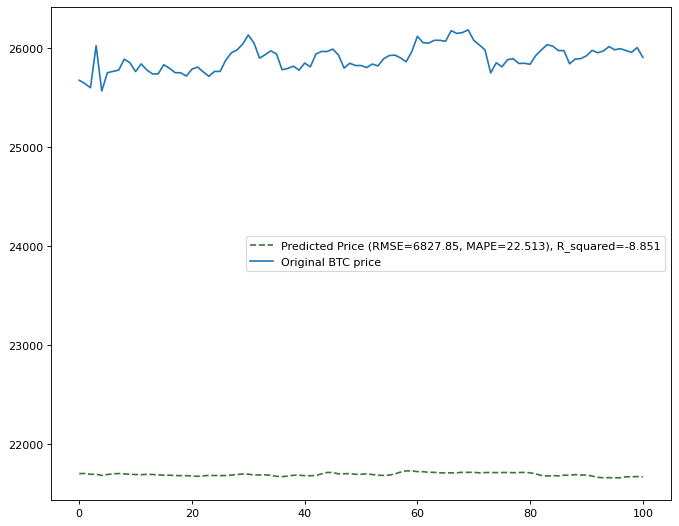

In [54]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction[0:101], linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f}".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist()[0:101], label = 'Original BTC price')
plt.legend()
plt.show()

#### CNN LSTM

In [26]:
def perform_CnnLSTM(dataset, look_back, layer = 4, epochs = 100, batch_size = 16, validation_split = 0.2,
                    filters = 32, kernel_size = 1):
  
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the data -- using Min and Max values in each subsequence to normalize the values
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Split data into training and testing set
    train_size = len(dataset) - 500
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1], 1))

    # create and fit the LSTM network
    model = tf.keras.models.Sequential()

    model.add(TimeDistributed(Conv1D(filters = filters, kernel_size = kernel_size, activation='relu'),
                                       input_shape = (None, look_back, 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    model.add(TimeDistributed(Flatten()))
    # Add a hidden layer with input dimensions, neurons and activation function

    model.add(LSTM(units = layer, kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                        activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    # Add output layer with one 1 ouput neuron as this is regression problem
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size,
              verbose = 2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

In [36]:
IMF_predict_list = []
error_list = []
for IMF in IMFs:
    iter_ = len(error_list) + 1
    print(f'========================================Training for IMF: {iter_}========================================')
    IMF_predict, IMF_test, testing_error = perform_CnnLSTM(IMF, 5, layer = 1, epochs = 50,
                                                        batch_size = 32, filters = 32, kernel_size = 1)
    error_list.append(testing_error)
    IMF_predict_list.append(IMF_predict)
    print('')

========================================Training for IMF: 1========================================
Epoch 1/50
243/243 - 2s - loss: 0.0851 - 2s/epoch - 9ms/step
Epoch 2/50
243/243 - 1s - loss: 0.0054 - 999ms/epoch - 4ms/step
Epoch 3/50
243/243 - 1s - loss: 0.0054 - 952ms/epoch - 4ms/step
Epoch 4/50
243/243 - 1s - loss: 0.0054 - 945ms/epoch - 4ms/step
Epoch 5/50
243/243 - 1s - loss: 0.0054 - 944ms/epoch - 4ms/step
Epoch 6/50
243/243 - 1s - loss: 0.0054 - 938ms/epoch - 4ms/step
Epoch 7/50
243/243 - 1s - loss: 0.0054 - 947ms/epoch - 4ms/step
Epoch 8/50
243/243 - 1s - loss: 0.0054 - 945ms/epoch - 4ms/step
Epoch 9/50
243/243 - 1s - loss: 0.0054 - 927ms/epoch - 4ms/step
Epoch 10/50
243/243 - 1s - loss: 0.0053 - 940ms/epoch - 4ms/step
Epoch 11/50
243/243 - 1s - loss: 0.0053 - 954ms/epoch - 4ms/step
Epoch 12/50
243/243 - 1s - loss: 0.0053 - 950ms/epoch - 4ms/step
Epoch 13/50
243/243 - 1s - loss: 0.0053 - 991ms/epoch - 4ms/step
Epoch 14/50
243/243 - 1s - loss: 0.0053 - 939ms/epoch - 4ms/step
Ep

Epoch 20/50
243/243 - 1s - loss: 0.0023 - 944ms/epoch - 4ms/step
Epoch 21/50
243/243 - 1s - loss: 0.0023 - 935ms/epoch - 4ms/step
Epoch 22/50
243/243 - 1s - loss: 0.0023 - 923ms/epoch - 4ms/step
Epoch 23/50
243/243 - 1s - loss: 0.0023 - 949ms/epoch - 4ms/step
Epoch 24/50
243/243 - 1s - loss: 0.0023 - 924ms/epoch - 4ms/step
Epoch 25/50
243/243 - 1s - loss: 0.0023 - 938ms/epoch - 4ms/step
Epoch 26/50
243/243 - 1s - loss: 0.0023 - 924ms/epoch - 4ms/step
Epoch 27/50
243/243 - 1s - loss: 0.0023 - 941ms/epoch - 4ms/step
Epoch 28/50
243/243 - 1s - loss: 0.0023 - 993ms/epoch - 4ms/step
Epoch 29/50
243/243 - 1s - loss: 0.0023 - 930ms/epoch - 4ms/step
Epoch 30/50
243/243 - 1s - loss: 0.0023 - 924ms/epoch - 4ms/step
Epoch 31/50
243/243 - 1s - loss: 0.0023 - 938ms/epoch - 4ms/step
Epoch 32/50
243/243 - 1s - loss: 0.0023 - 939ms/epoch - 4ms/step
Epoch 33/50
243/243 - 1s - loss: 0.0023 - 929ms/epoch - 4ms/step
Epoch 34/50
243/243 - 1s - loss: 0.0023 - 927ms/epoch - 4ms/step
Epoch 35/50
243/243 - 1s 

Epoch 36/50
243/243 - 1s - loss: 6.2136e-05 - 914ms/epoch - 4ms/step
Epoch 37/50
243/243 - 1s - loss: 6.4747e-05 - 907ms/epoch - 4ms/step
Epoch 38/50
243/243 - 1s - loss: 6.0498e-05 - 907ms/epoch - 4ms/step
Epoch 39/50
243/243 - 1s - loss: 6.2803e-05 - 885ms/epoch - 4ms/step
Epoch 40/50
243/243 - 1s - loss: 5.9944e-05 - 908ms/epoch - 4ms/step
Epoch 41/50
243/243 - 1s - loss: 5.9292e-05 - 908ms/epoch - 4ms/step
Epoch 42/50
243/243 - 1s - loss: 5.8931e-05 - 901ms/epoch - 4ms/step
Epoch 43/50
243/243 - 1s - loss: 6.1003e-05 - 905ms/epoch - 4ms/step
Epoch 44/50
243/243 - 1s - loss: 5.9493e-05 - 905ms/epoch - 4ms/step
Epoch 45/50
243/243 - 1s - loss: 5.6199e-05 - 894ms/epoch - 4ms/step
Epoch 46/50
243/243 - 1s - loss: 5.6883e-05 - 898ms/epoch - 4ms/step
Epoch 47/50
243/243 - 1s - loss: 5.9363e-05 - 963ms/epoch - 4ms/step
Epoch 48/50
243/243 - 1s - loss: 5.4963e-05 - 971ms/epoch - 4ms/step
Epoch 49/50
243/243 - 1s - loss: 5.9899e-05 - 910ms/epoch - 4ms/step
Epoch 50/50
243/243 - 1s - loss: 5

16/16 [==============================] - 0s 2ms/step

========================================Training for IMF: 8========================================
Epoch 1/50
243/243 - 2s - loss: 0.1136 - 2s/epoch - 9ms/step
Epoch 2/50
243/243 - 1s - loss: 0.0194 - 943ms/epoch - 4ms/step
Epoch 3/50
243/243 - 1s - loss: 0.0085 - 921ms/epoch - 4ms/step
Epoch 4/50
243/243 - 1s - loss: 0.0033 - 919ms/epoch - 4ms/step
Epoch 5/50
243/243 - 1s - loss: 0.0021 - 904ms/epoch - 4ms/step
Epoch 6/50
243/243 - 1s - loss: 0.0016 - 919ms/epoch - 4ms/step
Epoch 7/50
243/243 - 1s - loss: 0.0012 - 930ms/epoch - 4ms/step
Epoch 8/50
243/243 - 1s - loss: 9.0246e-04 - 934ms/epoch - 4ms/step
Epoch 9/50
243/243 - 1s - loss: 6.7407e-04 - 929ms/epoch - 4ms/step
Epoch 10/50
243/243 - 1s - loss: 5.0558e-04 - 976ms/epoch - 4ms/step
Epoch 11/50
243/243 - 1s - loss: 3.9532e-04 - 938ms/epoch - 4ms/step
Epoch 12/50
243/243 - 1s - loss: 3.0364e-04 - 903ms/epoch - 4ms/step
Epoch 13/50
243/243 - 1s - loss: 2.2076e-04 - 918ms/epoch 

243/243 - 1s - loss: 2.5212e-04 - 913ms/epoch - 4ms/step
Epoch 13/50
243/243 - 1s - loss: 2.3229e-04 - 929ms/epoch - 4ms/step
Epoch 14/50
243/243 - 1s - loss: 2.1408e-04 - 915ms/epoch - 4ms/step
Epoch 15/50
243/243 - 1s - loss: 1.9839e-04 - 901ms/epoch - 4ms/step
Epoch 16/50
243/243 - 1s - loss: 1.7675e-04 - 914ms/epoch - 4ms/step
Epoch 17/50
243/243 - 1s - loss: 1.5871e-04 - 975ms/epoch - 4ms/step
Epoch 18/50
243/243 - 1s - loss: 1.4264e-04 - 915ms/epoch - 4ms/step
Epoch 19/50
243/243 - 1s - loss: 1.2167e-04 - 912ms/epoch - 4ms/step
Epoch 20/50
243/243 - 1s - loss: 1.0449e-04 - 918ms/epoch - 4ms/step
Epoch 21/50
243/243 - 1s - loss: 8.5932e-05 - 917ms/epoch - 4ms/step
Epoch 22/50
243/243 - 1s - loss: 7.1055e-05 - 903ms/epoch - 4ms/step
Epoch 23/50
243/243 - 1s - loss: 5.7260e-05 - 916ms/epoch - 4ms/step
Epoch 24/50
243/243 - 1s - loss: 4.5856e-05 - 916ms/epoch - 4ms/step
Epoch 25/50
243/243 - 1s - loss: 3.8283e-05 - 925ms/epoch - 4ms/step
Epoch 26/50
243/243 - 1s - loss: 3.1534e-05 - 

In [37]:
for i in IMF_predict_list:
    i = i[:,0]

# This nested for loop is used to generate final prediction by adding up the corresponding values in each subsequence
final_prediction = []
for i in range(len(IMF_predict_list[0])):
    element = 0 
    for j in range(len(IMF_predict_list)):
        element += IMF_predict_list[j][i]
    final_prediction = final_prediction + element.tolist()

In [39]:
from sklearn.metrics import r2_score
SP = time_y.astype('float32')
SP = np.reshape(SP.to_numpy(), (-1, 1))

train_size = train_size = len(SP) - 500
test_size = len(SP) - train_size
SP_train, SP_test = SP[0:train_size], SP[train_size:]

SP_testX, SP_testY = create_dataset(SP_test, 5)

# Calculate the RMSE
rmse_error = rmse(SP_testY.tolist(), final_prediction)
mdape_error = MAPE(SP_testY.tolist(), final_prediction)
r2 = r2_score(SP_testY.tolist(), final_prediction)

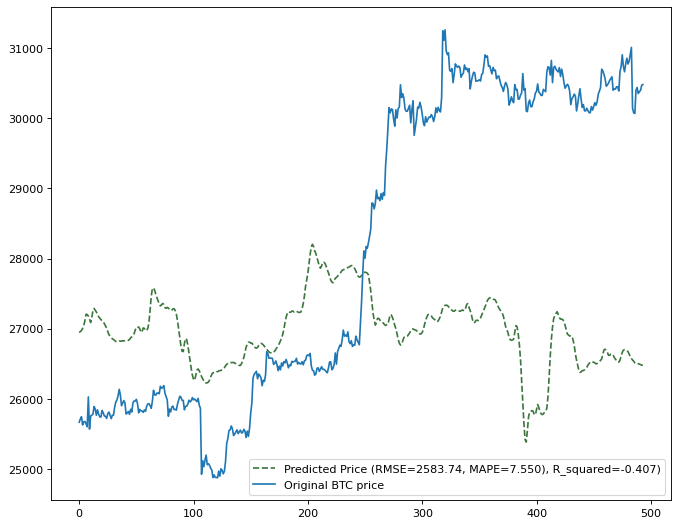

In [40]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction, linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f})".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist(), label = 'Original BTC price')
plt.legend()
plt.show()

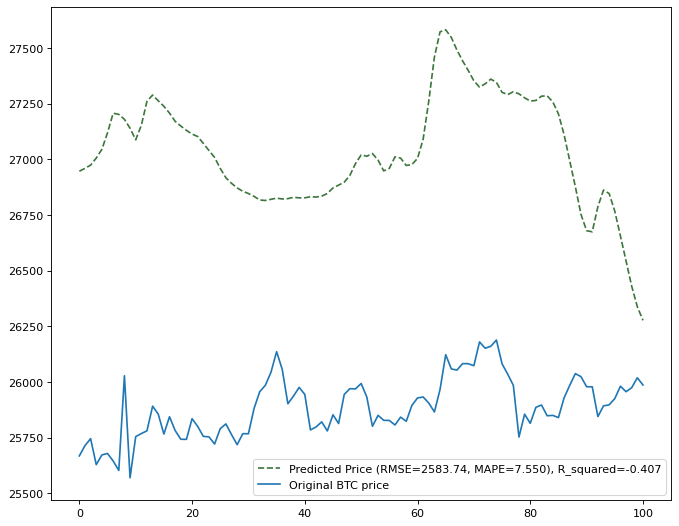

In [41]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(final_prediction[0:101], linestyle='--', color='#3c763d',
         label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}), R_squared={:0.3f}".format(rmse_error, float(mdape_error), r2))
plt.plot(SP_testY.tolist()[0:101], label = 'Original BTC price')
plt.legend()
plt.show()